<h1 align="center"> PCA + Logistic Regression (MNIST) </h1>

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
<br>
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. 

Parameters | Number
--- | ---
Classes | 10
Samples per class | ~7000 samples per class
Samples total | 70000
Dimensionality | 784
Features | integers values from 0 to 255

The MNIST database of handwritten digits is available on the following website: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)

Four Files are available on this site:

[train-images-idx3-ubyte.gz:  training set images (9912422 bytes)](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz) 
<br>
[train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)](http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz)
<br>
[t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz) 
<br>
[t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz)

In [6]:
import pandas as pd
import numpy as np 
# Suppress scientific notation
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Used for Loading MNIST
from struct import unpack

%matplotlib inline

## Downloading MNIST Dataset

<b>If you cant unzip the file, you can try gzip or download it from [my github](https://github.com/mGalarnyk/Python_Tutorials/tree/master/Sklearn/Logistic_Regression/data)</b>

In [7]:
# decompress gzipped file
# !info gzip
# !gzip -d data/*.gz

## Loading MNIST Dataset

In [8]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

In [9]:
train_img, train_lbl = loadmnist('data/train-images-idx3-ubyte'
                                 , 'data/train-labels-idx1-ubyte')
test_img, test_lbl = loadmnist('data/t10k-images-idx3-ubyte'
                               , 'data/t10k-labels-idx1-ubyte')

In [10]:
print(train_img.shape)

(60000, 784)


In [11]:
print(train_lbl.shape)

(60000,)


In [12]:
print(test_img.shape)

(10000, 784)


In [13]:
print(test_lbl.shape)

(10000,)


## Showing Training Digits and Labels

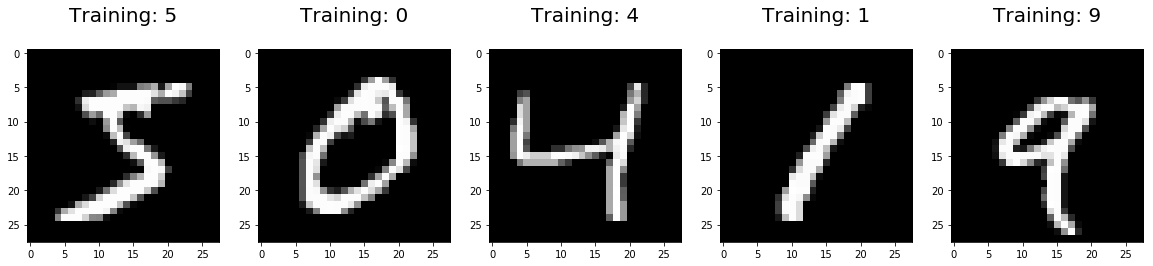

In [14]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_img[0:5], train_lbl[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [15]:
# This is how the computer sees the number 5
print(train_img[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

## Find Number of Principal Components with 95% of Explained Variance

Train PCA by requesting the projection preserve 95% of the variance. Common to choose number of principal components such that a percentage of the variance is retained (in this case 95%)

In [16]:
pca = PCA(.95)

In [17]:
pca.fit(train_img)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
# 95% of the variance amounts to 154 principal components
pca.n_components_

154

The idea with going from 784 components to 154 is to reduce the running time of a supervised learning algorithm (in this case logistic regression) which we will see at the end of the tutorial. One of the cool things about PCA is that we can go from a compressed representation (154 components) back to an approximation of our original high dimensional data (784 components). 

In [19]:
components = pca.transform(train_img)
approximation = pca.inverse_transform(components)

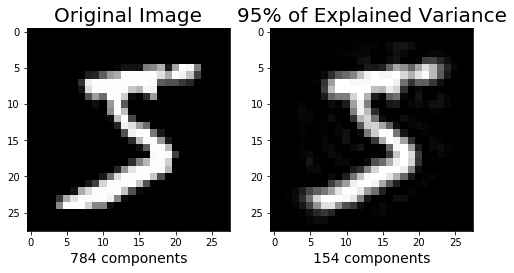

In [20]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_img[0].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

## Showing Graph of Explained Variance vs Number of Principal Components

In [21]:
# if n_components is not set all components are kept (784 in this case)
pca = PCA()

In [22]:
pca.fit(train_img)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
pca.n_components_

784

In [24]:
# Summing explained variance
tot = sum(pca.explained_variance_)
tot

3428502.5747802043

In [25]:
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])

[9.7046643597139379, 7.0959240590944637, 6.1690887623681423, 5.389419486553364, 4.8687970234748263]


In [26]:
tot = sum(pca.explained_variance_)
tot

3428502.5747802043

In [27]:
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])

[9.7046643597139379, 7.0959240590944637, 6.1690887623681423, 5.389419486553364, 4.8687970234748263]


In [28]:
# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp) 

Plot can help you understand the level of redundancy present in multiple dimensions.

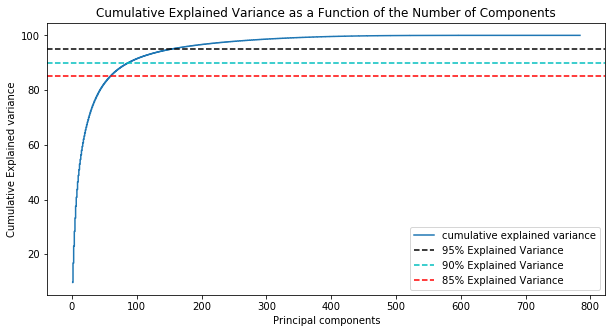

In [29]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.step(range(1, 785), cum_var_exp, where='mid',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend(loc='best')
plt.show()

## Number of Principal Components for 99%, 95%, 90%, and 85% of Explained Variance

In [30]:
# Indices corresponding to the first occurrence are returned with the np.argmax function
# Adding 1 to the end of value in list as principal components start from 1 and indexes start from 0 (np.argmax)
componentsVariance = [784, np.argmax(cum_var_exp > 99) + 1, np.argmax(cum_var_exp > 95) + 1, np.argmax(cum_var_exp > 90) + 1, np.argmax(cum_var_exp >= 85) + 1]

In [31]:
componentsVariance

[784, 331, 154, 87, 59]

In [32]:
from sklearn.decomposition import PCA

# This is an extremely inefficient function. Will get to why in a later tutorial
def explainedVariance(percentage, images): 
    # percentage should be a decimal from 0 to 1 
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    approxOriginal = pca.inverse_transform(components)
    return approxOriginal

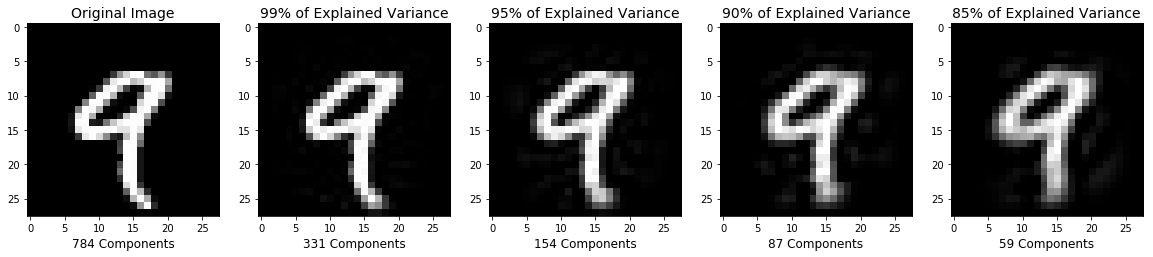

In [34]:
plt.figure(figsize=(20,4));

# Original Image (784 components)
plt.subplot(1, 5, 1);
plt.imshow(train_img[4].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 Components', fontsize = 12)
plt.title('Original Image', fontsize = 14);

# 331 principal components
plt.subplot(1, 5, 2);
plt.imshow(explainedVariance(.99, train_img)[4].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('331 Components', fontsize = 12)
plt.title('99% of Explained Variance', fontsize = 14);

# 154 principal components
plt.subplot(1, 5, 3);
plt.imshow(explainedVariance(.95, train_img)[4].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 Components', fontsize = 12)
plt.title('95% of Explained Variance', fontsize = 14);

# 87 principal components
plt.subplot(1, 5, 4);
plt.imshow(explainedVariance(.90, train_img)[4].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('87 Components', fontsize = 12)
plt.title('90% of Explained Variance', fontsize = 14);

# 59 principal components
plt.subplot(1, 5, 5);
plt.imshow(explainedVariance(.85, train_img)[4].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('59 Components', fontsize = 12)
plt.title('85% of Explained Variance', fontsize = 14);

## PCA to Speed up Machine Learning Algorithms (Logistic Regression)

Mention how long it takes for me to run classification with 99, 95, 90, 85 (maybe make a table). Go that PCA is not necessary in every data science workflow


Need to put the steps for applying PCA for machine learning applications
1. Fit PCA on training set. <b>Note: we are fitting PCA on the training set only</b>
2. Apply the mapping (transform) to both the training set and the test set. 
3. Train your machine learning algorithm (in this case logistic regression) on the transformed training set
4. Test your machine learning algorithm on the transformed test set.


[Logistic Regression Sklearn Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) <br>
One thing I like to mention is the importance of parameter tuning. While it may not have mattered much for the toy digits dataset, it can make a major difference on larger and more complex datasets you have. <b>Please see the parameter: solver (if you think the algorithm is too slow)</b>

<b>Step 1: </b> Import the model you want to use

In sklearn, all machine learning models are implemented as Python classes

In [53]:
from sklearn.linear_model import LogisticRegression 

<b>Step 2:</b> Make an instance of the Model

<b>time it on my computer with and without PCA for viewers benefit</b>

In [54]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow thats why we change it
# solver = 'lbfgs'
logisticRegr = LogisticRegression()

<b>Step 3:</b> Training the model on the data, storing the information learned from the data

Model is learning the relationship between x (digits) and y (labels)

In [55]:
logisticRegr.fit(train_img_PCA, train_lbl)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<b>Step 4:</b> Predict the labels of new data (new images)

Uses the information the model learned during the model training process

In [56]:
# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(test_img_PCA[0].reshape(1,-1))

array([7], dtype=uint8)

In [57]:
# Predict for Multiple Observations (images) at Once
logisticRegr.predict(test_img_PCA[0:10])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=uint8)

## Measuring Model Performance

accuracy (fraction of correct predictions): correct predictions / total number of data points

Basically, how the model performs on new data (test set)

(maybe look into F1 score with this just to change it up a bit, dont want viewers to think accuracy is only useful metric)

In [49]:
score = logisticRegr.score(test_img_PCA, test_lbl)
print(score)

0.9088


http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html or F1